<a href="https://colab.research.google.com/github/thanhtruong1712/DAMH_LTSSUD/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Đồ án môn học "Lập trình song song ứng dụng"

# Xác định loại bệnh thực vật bằng phương pháp trích xuất dữ liệu và mô hình XGBoost.

## Giảng viên: Phạm Trọng Nghĩa

### Nhóm 14:
- 1712771 - Bùi Thái Tấn Thành
- 1712770 - Trương Thị Lệ Thanh


---

# 1. Mô tả ứng dụng

- **Xác định loại bệnh thực vật bằng phương pháp trích xuất dữ liệu và mô hình XGBoost**
	- Input: một ảnh RGB (ảnh lá cây) và một mô hình XGBoost đã train
	- Output: `healthy`	`multiple_diseases`	`rust`	`scab`
	- Ý nghĩa của ứng dụng trong thực tế:
		- Tránh các chẩn đoán sai dẫn đến tăng chi phí, hại môi trường khi sự dụng sai thuốc, hóa chất cho cây trồng
		- Chẩn đoán hiện tại dựa trên con người: tốn thời gian, tốn kém và không mang lại hiệu quả 


> ![](https://github.com/ManCB26/22/blob/main/images_APP/Frame%201.png?raw=true)













- Lý do cần tăng tốc ứng dụng:
	- Có nhiều ý nghĩa thực tế, có thể áp dụng cho đa dạng loại thực vật; riêng trích xuất dữ liệu có thể áp dụng cho các bài toán dạng ảnh.
	- Ứng dụng này sẽ chạy chậm nếu cài đặt tuần tự
	- Mô hình XGBoost có thể song song hóa và tối ưu hóa.
	





- Khả năng song song hóa
	- Các bước tiền xử lý có thể song song hóa.
	- Các cây độc lập với nhau

---

# 2. Cài đặt tuần tự

## 2.1. Phân tích
Các bước được thực hiện cài đặt tuần tự:
- Chuyển ảnh màu sang ảnh xám.
- Đạo hàm ảnh bằng phương pháp candy. (Không tuần tự mà dùng thư viện)
- Nén ảnh với threshold và liên kết các ô xung quanh để lấp khuyết ảnh.
- Trích xuất Color histogram và Hue moments
- Lấy trọng số từ mô hình XGBoost và thực hiện tính toán

## 2.2. Thiết kế


####**2.2.1**. **Trích xuất dữ liệu**







---


> - Sử dụng đạo hàm ảnh bằng phương pháp Candy 
    
> - Sử dụng phương pháp nén ảnh với threshold và liên kết các ô xung quanh để lấp khuyết ảnh
> - Hàm dùng để nén ảnh với threshold là ratio sẽ trả ra kết quả là ảnh với block tương ứng với zip x zip và nếu block nào không đủ pixel yêu cầu thì là 0 còn ngược lại thì là 1
    - Hàm dùng để liên kết các ô xung quanh để lấp khuyết sẽ trả ra kết quả là một ma trận mask
    

> - Trích xuất dữ liệu từ dạng ảnh sang dạng số
    - Color histogram: thống kê số lần xuất hiện các mức sáng trong ảnh với bins=8, phạm vi [0,256] cho mỗi kênh màu
    - [Hue moments](https://en.wikipedia.org/wiki/Image_moment): 
    >> - 7 giá trị với 1-6 là đối xứng phản xạ, 7 là phản xạ phản đối xứng 
    >> - Các giá trị này được chứng minh là bất biến đối với tỷ lệ hình ảnh, phép quay và độ phản xạ ngoại trừ giá trị thứ bảy, có dấu hiệu bị thay đổi do phản xạ. Sự bất biến này được chứng minh với giả thiết về độ phân giải ảnh vô hạn. Trong trường hợp ảnh raster, các bất biến Hu được tính toán cho ảnh gốc và ảnh đã biến đổi có một chút khác biệt. ([OpenCV](https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cvmatchshapes#humoments))

**Output:** mảng 519 giá trị gồm 512 giá trị color histogram, 7 giá trị hue moments




####**2.2.2**. **Dự đoán từ dữ liệu đã được trích xuất và mô hình XGBoost đã train**


Kiến trúc tổng quát của **XGBoost** ![](https://www.researchgate.net/profile/Li-Mingtao-2/publication/335483097/figure/fig3/AS:934217085100032@1599746118459/A-general-architecture-of-XGBoost.ppm) 



- Khởi tạo mô hình XGBoost với các siêu tham số:
    - n_estimators: 75
    - learning_rate: 0.2
    - max_depth: 6
- Huấn luyện mô hình với dữ liệu huấn luyện đã qua bước trích xuất đặc trưng:
    - Xác định số mẫu, số phân lớp.
    - Khởi tạo dự đoán theo phân bố đối tượng trong tập dữ liệu.
    - Với mỗi cây thành phần:
        - Xây dựng cây từ dữ liệu huấn luyện và dự đoán ban đầu.
        - Dự đoán nhãn trên dữ liệu huấn luyện.
        - Cập nhật dự đoán ban đầu.
        
Trong đó quá trình xây dựng cây được thực hiện như sau:
- Kiểm tra điều kiện dừng:
    - Độ sâu cây đạt ngưỡng tối đa.
    - Tập dữ liệu chỉ có 1 lớp.
    - Số đối tượng tại nút ít hơn tối thiểu.
- Tìm cột đặc trưng và ngưỡng giá trị tốt nhất để phân nhánh.
- Tạo nút con trái và phải



**Lưu đồ quá trình huấn luyện mô hình XGBoost**

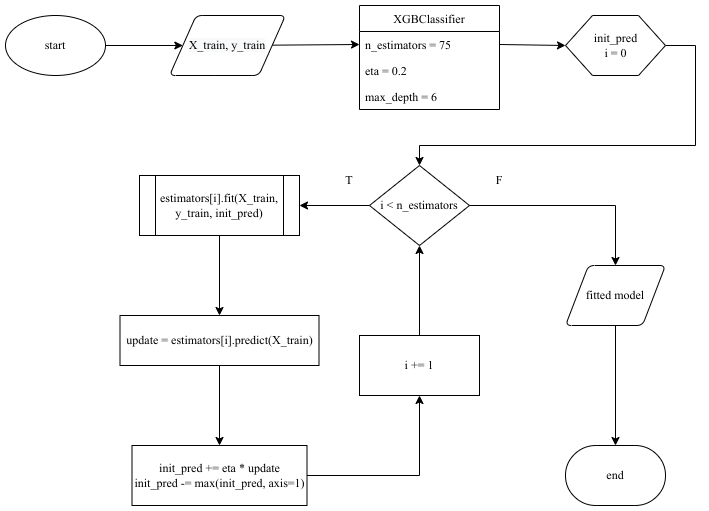

Giá trị của nút lá j được tính:
$w^*_j = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}$

Trong đó:
- $I_j$ là tập các đối tượng tại nút $j$.
- $g_i, h_i$ lần lượt là các giá trị đạo hàm bậc 1 và 2 của hàm mất mát cross entropy.

**Hàm mất mát cross entropy:**
$\mathsf{CE}(y,s) = \sum^C_{i=1}\enspace y_i \times \log(s_i)$

với $s_i$ là hàm softmax cho điểm dự đoán $z_i$ của nhãn $i \Rightarrow$
$s_i = \frac{e^{z_i}}{\sum^C_{i=1}e^{z_j}}$

**Đạo hàm của cross entropy:**
- Đạo hàm [bậc 1](https://math.stackexchange.com/questions/945871/derivative-of-softmax-loss-function):
$\frac{\partial \mathsf{CE}}{\partial z_i} = s_i - y_i$
- Đạo hàm [bậc 2](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1):
$\frac{\partial^2 \mathsf{CE}}{\partial z_j^2} = \frac{\partial s_i}{\partial z_j}
= s_i \times (1\{i = j\} - s_j)$

**Lưu đồ quá trình xây dựng cây thành phần**

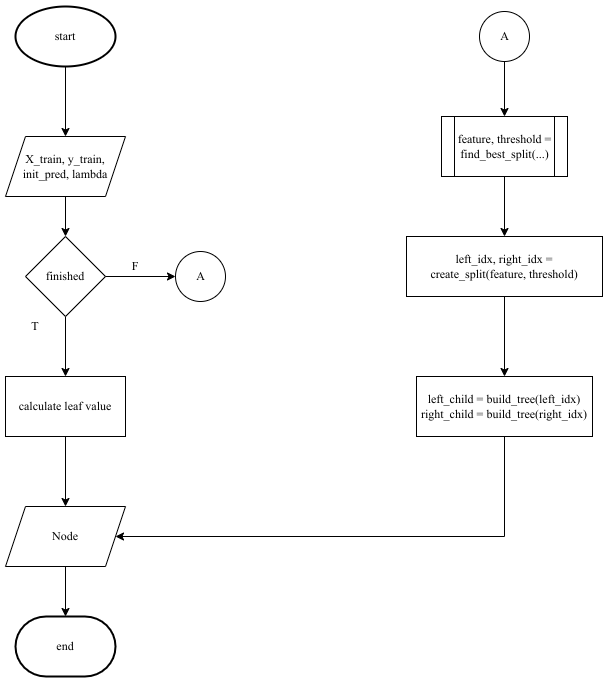

**Hàm find_best_split** lần lượt duyệt qua các đặc trưng:
- Tìm các giá trị phân biệt.
- Chia dữ liệu theo giá trị trên.
- Tính độ lợi với cách chia đề xuất.

Hàm trả về đặc trưng và giá trị ngưỡng có độ lợi cao nhất.

Độ lợi của 1 phương án phân nhánh đề xuất được tính theo [công thức](https://www.youtube.com/watch?v=ZVFeW798-2I&list=PLblh5JKOoLULU0irPgs1SnKO6wqVjKUsQ&index=3):
$\mathsf{gain} = \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{G^2}{H + \lambda}$

Trong đó:
- $G, H$ lần lượt là tổng các đạo hàm bậc 1 và 2 hàm $\mathsf{CE}$ của các đối tượng.
    - $G_L, H_L$ ứng với các đối tượng dự kiến ở nút con trái, $G_R, H_R$ là ở nút con phải.
    - $G = G_L + G_R, H = H_L + H_R$

## 2.3. Đánh giá

# 3. Cài đặt song song

## 3.1. Phân tích

## 3.2. Thiết kế

## 3.3. Đánh giá

---

# 4. Nhìn lại quá trình làm đồ án

---

# 5. Tài liệu tham khảo

- Nhập môn học máy: [BÀI TẬP THỰC HÀNH II ](https://drive.google.com/file/d/1U65IfdkizLD0pd1aQKp9xqVRnTj5bejR/view)
- [Image moment - Wiki](https://en.wikipedia.org/wiki/Image_moment)

- https://towardsdatascience.com/using-nmf-to-classify-companies-a77e176f276f
- https://github.com/jonasrothfuss/fishervector
- https://hal.inria.fr/hal-00779493/file/RR-8209.pdf
- https://viblo.asia/p/sift-scale-invariant-feature-transform-huan-luyen-mo-hinh-cho-cac-bai-toan-phan-loai-924lJqJaZPM
- https://xgboost.readthedocs.io/en/stable/
- https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
- https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb
- https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
- https://www.smartdraw.com/flowchart/flowchart-symbols.htm
- https://en.wikipedia.org/wiki/Image_moment#cite_note-%E2%80%9Chu-1
- [OpenCV RGB histogram calculation and drawing----calcHist() function, normalize() function](https://www.programmerall.com/article/5123272509/)

